In [31]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import os

import folium

In [32]:
# Connect to the dev.duckdb database located in the dbt_pollution/ directory
db_path = os.path.join(os.path.dirname(os.getcwd()), 'dev.duckdb')
conn = duckdb.connect(db_path)
print(f'Connected to database at {db_path} successfully!')

# Show available tables
tables = conn.execute('SHOW TABLES').fetchall()
print('\nAvailable tables:')
for table in tables:
    print(f'- {table[0]}')

Connected to database at /Users/MPC/Documents/Github-Personal/pollution-prediction/dbt_pollution/dev.duckdb successfully!

Available tables:
- instrument_data
- lnd_instrument_data
- lnd_measurements
- lnd_pollutants
- measurement_data
- pollutant_data


#### Pollutants Data

In [33]:
# Query the pollutant_data table and display as a dataframe
pollutant_df = conn.execute("SELECT * FROM lnd_pollutants").df()
display(pollutant_df)

,item_code,item_name,unit_of_measurement,good,normal,bad,very_bad
0,0,so2,ppm,0.02,0.05,0.15,1.0
1,2,no2,ppm,0.03,0.06,0.20,2.0
2,4,co,ppm,2.00,9.00,15.00,50.0
3,5,o3,ppm,0.03,0.09,0.15,0.5
4,7,pm10,mg/m3,30.00,80.00,150.00,600.0
5,8,pm2.5,mg/m3,15.00,35.00,75.00,500.0


### Instrument Data

In [34]:
# Query lnd_instrument_data and left join to lnd_pollutants to get item_name
instrument_df = conn.execute("""
    SELECT i.*, p.item_name
    FROM lnd_instrument_data i
    LEFT JOIN lnd_pollutants p
      ON i.item_code = p.item_code
""").df()
display(instrument_df)

,measurement_datetime,station_code,item_code,average_value,instrument_status,item_name
0,2023-05-13 16:00:00,204,7,49.000,0,pm10
1,2023-05-13 16:00:00,204,5,0.049,0,o3
2,2023-05-13 16:00:00,204,0,0.005,0,so2
3,2023-05-13 16:00:00,204,4,0.500,0,co
4,2023-05-13 16:00:00,204,2,0.046,0,no2
...,...,...,...,...,...,...
3703657,2021-10-25 02:00:00,226,2,0.046,0,no2
3703658,2021-10-25 02:00:00,226,4,0.600,0,co
3703659,2021-10-25 02:00:00,226,5,0.002,0,o3
3703660,2021-10-25 02:00:00,226,7,41.000,0,pm10


In [35]:
# Create comprehensive unified dataset for all analysis tasks
print("=== CREATING UNIFIED POLLUTION DATASET ===")
print("Combining measurement data (spatial info) + instrument data (quality info)")

# Use DuckDB's columnar efficiency to create one comprehensive dataset
unified_query = """
WITH instrument_pivoted AS (
    SELECT 
        measurement_datetime,
        station_code,
        MAX(CASE WHEN item_code = 0 THEN average_value END) as so2_value,
        MAX(CASE WHEN item_code = 2 THEN average_value END) as no2_value, 
        MAX(CASE WHEN item_code = 4 THEN average_value END) as co_value,
        MAX(CASE WHEN item_code = 5 THEN average_value END) as o3_value,
        MAX(CASE WHEN item_code = 7 THEN average_value END) as pm10_value,
        MAX(CASE WHEN item_code = 8 THEN average_value END) as pm2_5_value,
        -- Quality indicators per pollutant
        MAX(CASE WHEN item_code = 0 THEN instrument_status END) as so2_status,
        MAX(CASE WHEN item_code = 2 THEN instrument_status END) as no2_status,
        MAX(CASE WHEN item_code = 4 THEN instrument_status END) as co_status,
        MAX(CASE WHEN item_code = 5 THEN instrument_status END) as o3_status,
        MAX(CASE WHEN item_code = 7 THEN instrument_status END) as pm10_status,
        MAX(CASE WHEN item_code = 8 THEN instrument_status END) as pm2_5_status,
        -- Overall quality score (0 = all normal, >0 = some issues)
        SUM(CASE WHEN instrument_status != 0 THEN 1 ELSE 0 END) as quality_issues_count,
        -- Binary flag for completely clean readings
        CASE WHEN SUM(CASE WHEN instrument_status != 0 THEN 1 ELSE 0 END) = 0 
             THEN true ELSE false END as all_instruments_normal
    FROM lnd_instrument_data
    GROUP BY measurement_datetime, station_code
),
measurement_with_coords AS (
    SELECT DISTINCT 
        station_code,
        latitude,
        longitude
    FROM lnd_measurements
)
SELECT 
    ip.*,
    mc.latitude,
    mc.longitude,
    -- Add temporal features for analysis
    EXTRACT(YEAR FROM ip.measurement_datetime) as year,
    EXTRACT(MONTH FROM ip.measurement_datetime) as month,
    EXTRACT(DAY FROM ip.measurement_datetime) as day,
    EXTRACT(HOUR FROM ip.measurement_datetime) as hour,
    EXTRACT(DOW FROM ip.measurement_datetime) as day_of_week,
    -- Season classification
    CASE 
        WHEN EXTRACT(MONTH FROM ip.measurement_datetime) IN (12, 1, 2) THEN 'Winter'
        WHEN EXTRACT(MONTH FROM ip.measurement_datetime) IN (3, 4, 5) THEN 'Spring'
        WHEN EXTRACT(MONTH FROM ip.measurement_datetime) IN (6, 7, 8) THEN 'Summer'
        ELSE 'Fall'
    END as season
FROM instrument_pivoted ip
LEFT JOIN measurement_with_coords mc ON ip.station_code = mc.station_code
ORDER BY measurement_datetime, station_code
"""

print("Executing unified dataset query...")
unified_df = conn.execute(unified_query).df()

print(f"✅ Created unified dataset:")
print(f"   - Rows: {len(unified_df):,}")
print(f"   - Columns: {len(unified_df.columns)}")
print(f"   - Time range: {unified_df['measurement_datetime'].min()} to {unified_df['measurement_datetime'].max()}")
print(f"   - Stations: {unified_df['station_code'].nunique()}")
print(f"   - Records with all normal instruments: {unified_df['all_instruments_normal'].sum():,} ({unified_df['all_instruments_normal'].mean()*100:.1f}%)")

display(unified_df.head())

=== CREATING UNIFIED POLLUTION DATASET ===
Combining measurement data (spatial info) + instrument data (quality info)
Executing unified dataset query...


BinderException: Binder Error: Ambiguous reference to column name "station_code" (use: "ip.station_code" or "mc.station_code")

In [ ]:
# Check number of unique stations
num_stations = pivot_df['station_code'].nunique()
print(f"Number of unique stations: {num_stations}")

# For each station: min/max datetime and number of recordings
station_summary = (
    pivot_df
    .groupby('station_code')
    .agg(
        min_datetime=('measurement_datetime', 'min'),
        max_datetime=('measurement_datetime', 'max'),
        num_recordings=('measurement_datetime', 'count')
    )
    .reset_index()
)
print("Min/Max measurement_datetime and number of recordings for each station_code:")
display(station_summary)

Number of unique stations: 25
Min/Max measurement_datetime and number of recordings for each station_code:


,station_code,min_datetime,max_datetime,num_recordings
0,204,2021-01-01,2023-12-31 23:00:00,25905
1,205,2021-01-01,2023-10-31 23:00:00,24453
2,206,2021-01-01,2023-06-30 23:00:00,21593
3,207,2021-01-01,2023-12-31 23:00:00,25896
4,208,2021-01-01,2023-12-31 23:00:00,25890
5,209,2021-01-01,2023-08-31 23:00:00,23057
6,210,2021-01-01,2023-12-31 23:00:00,25891
7,211,2021-01-01,2023-07-31 23:00:00,22316
8,212,2021-01-01,2023-12-31 23:00:00,25904
9,213,2021-01-01,2023-12-31 23:00:00,25906


### Measurement Data

In [7]:
# Query the measurement_data table and display as a dataframe
measurement_df = conn.execute("SELECT * FROM lnd_measurements").df()
display(measurement_df)

,measurement_datetime,station_code,latitude,longitude,so2_value,no2_value,o3_value,co_value,pm10_value,pm2_5_value
0,2021-01-01 00:00:00,204,37.572016,127.005008,0.004,0.059,0.002,1.2,73.0,57.0
1,2021-01-01 01:00:00,204,37.572016,127.005008,0.004,0.058,0.002,1.2,71.0,59.0
2,2021-01-01 02:00:00,204,37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,59.0
3,2021-01-01 03:00:00,204,37.572016,127.005008,0.004,0.056,0.002,1.2,70.0,58.0
4,2021-01-01 04:00:00,204,37.572016,127.005008,0.003,0.051,0.002,1.2,69.0,61.0
...,...,...,...,...,...,...,...,...,...,...
621583,2023-11-30 19:00:00,228,37.544962,127.136792,0.005,0.061,0.002,0.7,72.0,18.0
621584,2023-11-30 20:00:00,228,37.544962,127.136792,0.005,0.060,0.003,0.7,64.0,18.0
621585,2023-11-30 21:00:00,228,37.544962,127.136792,0.005,0.061,0.003,0.7,55.0,18.0
621586,2023-11-30 22:00:00,228,37.544962,127.136792,0.004,0.053,0.005,0.6,50.0,18.0


In [18]:
# Get unique stations with their coordinates
station_locations = (
    measurement_df[['station_code', 'latitude', 'longitude']]
    .drop_duplicates(subset=['station_code'])
    .reset_index(drop=True)
)

# Calculate the center of the map
center_lat = station_locations['latitude'].mean()
center_lon = station_locations['longitude'].mean()

# Create a folium map centered at the average location
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add a marker for each station
for _, row in station_locations.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Station {row['station_code']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Display the map
display(m)


**Station Location Information**

- All 25 monitoring stations in this dataset are located in **South Korea**, most likely within the Seoul metropolitan area.
- The stations are distributed across various districts, providing comprehensive air quality coverage for the region.
- Each station is identified by a unique `station_code` and has associated geographic coordinates (`latitude`, `longitude`).

**Other Details:**
- The dataset covers years between 2021 and 2023 and includes hourly measurements for key pollutants (SO₂, NO₂, O₃, CO, PM10, PM2.5).
- The spatial distribution of stations allows for detailed analysis of air quality patterns across urban and suburban areas.
- The latitude and longitude values suggest all stations are within a relatively compact urban area, supporting high-resolution spatial analysis.

In [9]:

# Check number of unique stations
num_stations = measurement_df['station_code'].nunique()
print(f"Number of unique stations: {num_stations}")

# For each station: min/max datetime and number of recordings
station_summary = (
    measurement_df
    .groupby('station_code')
    .agg(
        min_datetime=('measurement_datetime', 'min'),
        max_datetime=('measurement_datetime', 'max'),
        num_recordings=('measurement_datetime', 'count')
    )
    .reset_index()
)
print("Min/Max measurement_datetime and number of recordings for each station_code:")
display(station_summary)

Number of unique stations: 25
Min/Max measurement_datetime and number of recordings for each station_code:


,station_code,min_datetime,max_datetime,num_recordings
0,204,2021-01-01,2023-12-31 23:00:00,25905
1,205,2021-01-01,2023-11-30 23:00:00,25173
2,206,2021-01-01,2023-06-30 23:00:00,21593
3,207,2021-01-01,2023-12-31 23:00:00,25896
4,208,2021-01-01,2023-12-31 23:00:00,25890
5,209,2021-01-01,2023-09-30 23:00:00,23709
6,210,2021-01-01,2023-12-31 23:00:00,25891
7,211,2021-01-01,2023-07-31 23:00:00,22316
8,212,2021-01-01,2023-12-31 23:00:00,25904
9,213,2021-01-01,2023-12-31 23:00:00,25906


In [25]:
# Deep Dive: Instrument Data vs Measurement Data Analysis

print("=== COMPARATIVE ANALYSIS: INSTRUMENT DATA vs MEASUREMENT DATA ===\n")

# 1. Data Structure Comparison
print("1. DATA STRUCTURE COMPARISON")
print("-" * 40)
print("Instrument Data Structure:")
print(f"- Rows: {len(instrument_df):,}")
print(f"- Columns: {list(instrument_df.columns)}")
print(f"- Key feature: Has 'instrument_status' field")
print(f"- Format: Long format (one row per pollutant per measurement)")

print("\nMeasurement Data Structure:")
print(f"- Rows: {len(measurement_df):,}")
print(f"- Columns: {list(measurement_df.columns)}")
print(f"- Key feature: Has lat/lon coordinates")
print(f"- Format: Wide format (one row per station per datetime)")

# 2. Coverage Comparison
print("\n2. DATA COVERAGE COMPARISON")
print("-" * 40)
instr_coverage = instrument_df.groupby(['station_code', 'item_name']).size().reset_index(name='instr_count')
meas_coverage = measurement_df.groupby('station_code').size().reset_index(name='meas_count')

print("Station coverage comparison:")
coverage_comparison = pd.merge(
    instr_coverage.groupby('station_code')['instr_count'].sum().reset_index(),
    meas_coverage,
    on='station_code',
    how='outer'
).fillna(0)
coverage_comparison['ratio'] = coverage_comparison['instr_count'] / (coverage_comparison['meas_count'] * 6)  # 6 pollutants expected
print(f"Expected ratio should be ~1.0 if data matches perfectly")
display(coverage_comparison.head(10))

=== COMPARATIVE ANALYSIS: INSTRUMENT DATA vs MEASUREMENT DATA ===

1. DATA STRUCTURE COMPARISON
----------------------------------------
Instrument Data Structure:
- Rows: 3,703,662
- Columns: ['measurement_datetime', 'station_code', 'item_code', 'average_value', 'instrument_status', 'item_name']
- Key feature: Has 'instrument_status' field
- Format: Long format (one row per pollutant per measurement)

Measurement Data Structure:
- Rows: 621,588
- Columns: ['measurement_datetime', 'station_code', 'latitude', 'longitude', 'so2_value', 'no2_value', 'o3_value', 'co_value', 'pm10_value', 'pm2_5_value']
- Key feature: Has lat/lon coordinates
- Format: Wide format (one row per station per datetime)

2. DATA COVERAGE COMPARISON
----------------------------------------
Station coverage comparison:
Expected ratio should be ~1.0 if data matches perfectly


,station_code,instr_count,meas_count,ratio
0,204,155430,25905,1.000000
1,205,146718,25173,0.971398
2,206,129558,21593,1.000000
3,207,155376,25896,1.000000
4,208,155340,25890,1.000000
5,209,138342,23709,0.972500
6,210,155346,25891,1.000000
7,211,133896,22316,1.000000
8,212,155424,25904,1.000000
9,213,155436,25906,1.000000


In [26]:
# 3. Value Comparison for Same Station & Time
print("\n3. VALUE COMPARISON ANALYSIS")
print("-" * 40)

# Pick a specific station and time period for detailed comparison
test_station = 204
test_date = '2021-01-01'

# Get measurement data for comparison
meas_sample = measurement_df[
    (measurement_df['station_code'] == test_station) & 
    (measurement_df['measurement_datetime'].dt.date == pd.to_datetime(test_date).date())
].head(24)  # First 24 hours

# Get instrument data for same period
instr_sample = instrument_df[
    (instrument_df['station_code'] == test_station) & 
    (instrument_df['measurement_datetime'].dt.date == pd.to_datetime(test_date).date())
]

print(f"Comparing data for Station {test_station} on {test_date}")
print(f"Measurement records: {len(meas_sample)}")
print(f"Instrument records: {len(instr_sample)}")

# Create side-by-side comparison for first few hours
if len(meas_sample) > 0 and len(instr_sample) > 0:
    # Pivot instrument data to wide format for comparison
    instr_wide = instr_sample.pivot_table(
        index=['measurement_datetime', 'station_code'],
        columns='item_name',
        values='average_value'
    ).reset_index()
    
    # Rename columns to match measurement data
    column_mapping = {
        'so2': 'so2_value',
        'no2': 'no2_value', 
        'o3': 'o3_value',
        'co': 'co_value',
        'pm10': 'pm10_value',
        'pm2.5': 'pm2_5_value'
    }
    instr_wide = instr_wide.rename(columns=column_mapping)
    
    # Merge for comparison
    comparison = pd.merge(
        meas_sample[['measurement_datetime', 'station_code', 'so2_value', 'no2_value', 'o3_value', 'co_value', 'pm10_value', 'pm2_5_value']],
        instr_wide[['measurement_datetime', 'station_code', 'so2_value', 'no2_value', 'o3_value', 'co_value', 'pm10_value', 'pm2_5_value']],
        on=['measurement_datetime', 'station_code'],
        suffixes=('_meas', '_instr')
    )
    
    print(f"\nSuccessful matches: {len(comparison)}")
    if len(comparison) > 0:
        print("\nFirst 5 hours comparison:")
        display(comparison.head())
        
        # Calculate differences
        pollutants = ['so2', 'no2', 'o3', 'co', 'pm10', 'pm2_5']
        differences = {}
        for pollutant in pollutants:
            meas_col = f'{pollutant}_value_meas'
            instr_col = f'{pollutant}_value_instr'
            if meas_col in comparison.columns and instr_col in comparison.columns:
                differences[pollutant] = (comparison[meas_col] - comparison[instr_col]).abs().mean()
        
        print(f"\nAverage absolute differences between datasets:")
        for pollutant, diff in differences.items():
            print(f"- {pollutant.upper()}: {diff:.6f}")
else:
    print("No matching data found for comparison")


3. VALUE COMPARISON ANALYSIS
----------------------------------------
Comparing data for Station 204 on 2021-01-01
Measurement records: 24
Instrument records: 144

Successful matches: 24

First 5 hours comparison:


,measurement_datetime,station_code,so2_value_meas,no2_value_meas,o3_value_meas,co_value_meas,pm10_value_meas,pm2_5_value_meas,so2_value_instr,no2_value_instr,o3_value_instr,co_value_instr,pm10_value_instr,pm2_5_value_instr
0,2021-01-01 00:00:00,204,0.004,0.059,0.002,1.2,73.0,57.0,0.004,0.059,0.002,1.2,73.0,57.0
1,2021-01-01 01:00:00,204,0.004,0.058,0.002,1.2,71.0,59.0,0.004,0.058,0.002,1.2,71.0,59.0
2,2021-01-01 02:00:00,204,0.004,0.056,0.002,1.2,70.0,59.0,0.004,0.056,0.002,1.2,70.0,59.0
3,2021-01-01 03:00:00,204,0.004,0.056,0.002,1.2,70.0,58.0,0.004,0.056,0.002,1.2,70.0,58.0
4,2021-01-01 04:00:00,204,0.003,0.051,0.002,1.2,69.0,61.0,0.003,0.051,0.002,1.2,69.0,61.0



Average absolute differences between datasets:
- SO2: 0.000000
- NO2: 0.000000
- O3: 0.000000
- CO: 0.000000
- PM10: 0.000000
- PM2_5: 0.000000


In [27]:
# 4. Instrument Status Analysis - The Key Differentiator
print("\n4. INSTRUMENT STATUS ANALYSIS")
print("-" * 40)

# Analyze instrument status distribution
status_counts = instrument_df['instrument_status'].value_counts().sort_index()
status_labels = {
    0: "Normal",
    1: "Need for calibration", 
    2: "Abnormal",
    4: "Power cut off",
    8: "Under repair",
    9: "Abnormal data"
}

print("Instrument Status Distribution:")
for status, count in status_counts.items():
    label = status_labels.get(status, f"Unknown ({status})")
    percentage = (count / len(instrument_df)) * 100
    print(f"- {status} ({label}): {count:,} records ({percentage:.2f}%)")

# Check if measurement data has any status information
print(f"\nMeasurement data has {len(measurement_df.columns)} columns:")
print(f"Columns: {list(measurement_df.columns)}")
print("✓ Measurement data does NOT have instrument_status information")
print("✓ This is the primary difference: instrument data tracks quality, measurement data doesn't")


4. INSTRUMENT STATUS ANALYSIS
----------------------------------------
Instrument Status Distribution:
- 0 (Normal): 3,606,696 records (97.38%)
- 1 (Need for calibration): 27,147 records (0.73%)
- 2 (Abnormal): 3,868 records (0.10%)
- 4 (Power cut off): 17,960 records (0.48%)
- 8 (Under repair): 28,323 records (0.76%)
- 9 (Abnormal data): 19,668 records (0.53%)

Measurement data has 10 columns:
Columns: ['measurement_datetime', 'station_code', 'latitude', 'longitude', 'so2_value', 'no2_value', 'o3_value', 'co_value', 'pm10_value', 'pm2_5_value']
✓ Measurement data does NOT have instrument_status information
✓ This is the primary difference: instrument data tracks quality, measurement data doesn't


In [28]:
# 5. Data Quality Impact Analysis
print("\n5. DATA QUALITY IMPACT ANALYSIS")
print("-" * 40)

# Compare values when instrument status is normal vs abnormal
normal_data = instrument_df[instrument_df['instrument_status'] == 0]
abnormal_data = instrument_df[instrument_df['instrument_status'] != 0]

print(f"Normal readings: {len(normal_data):,} ({len(normal_data)/len(instrument_df)*100:.1f}%)")
print(f"Abnormal readings: {len(abnormal_data):,} ({len(abnormal_data)/len(instrument_df)*100:.1f}%)")

# Statistical comparison for each pollutant
print("\nValue ranges by instrument status:")
for pollutant in ['so2', 'no2', 'o3', 'co', 'pm10', 'pm2.5']:
    normal_values = normal_data[normal_data['item_name'] == pollutant]['average_value']
    abnormal_values = abnormal_data[abnormal_data['item_name'] == pollutant]['average_value']
    
    if len(normal_values) > 0 and len(abnormal_values) > 0:
        print(f"\n{pollutant.upper()}:")
        print(f"  Normal - Mean: {normal_values.mean():.4f}, Std: {normal_values.std():.4f}, Range: [{normal_values.min():.4f}, {normal_values.max():.4f}]")
        print(f"  Abnormal - Mean: {abnormal_values.mean():.4f}, Std: {abnormal_values.std():.4f}, Range: [{abnormal_values.min():.4f}, {abnormal_values.max():.4f}]")

# Check temporal coverage differences
print(f"\nTemporal Coverage:")
instr_date_range = (instrument_df['measurement_datetime'].min(), instrument_df['measurement_datetime'].max())
meas_date_range = (measurement_df['measurement_datetime'].min(), measurement_df['measurement_datetime'].max())

print(f"Instrument data: {instr_date_range[0]} to {instr_date_range[1]}")
print(f"Measurement data: {meas_date_range[0]} to {meas_date_range[1]}")
print(f"Same time range? {instr_date_range == meas_date_range}")


5. DATA QUALITY IMPACT ANALYSIS
----------------------------------------
Normal readings: 3,606,696 (97.4%)
Abnormal readings: 96,966 (2.6%)

Value ranges by instrument status:

SO2:
  Normal - Mean: 0.0044, Std: 0.0017, Range: [0.0010, 0.0410]
  Abnormal - Mean: -0.2094, Std: 0.4165, Range: [-1.0000, 3.7360]

NO2:
  Normal - Mean: 0.0286, Std: 0.0160, Range: [0.0000, 0.1230]
  Abnormal - Mean: -0.2131, Std: 0.7255, Range: [-1.0000, 38.4450]

O3:
  Normal - Mean: 0.0247, Std: 0.0192, Range: [0.0000, 0.2150]
  Abnormal - Mean: -0.2052, Std: 0.5629, Range: [-1.0000, 33.6000]

CO:
  Normal - Mean: 0.5154, Std: 0.2405, Range: [0.0000, 3.2000]
  Abnormal - Mean: 0.2848, Std: 1.9799, Range: [-1.0000, 71.7000]

PM10:
  Normal - Mean: 42.0871, Std: 29.4842, Range: [1.0000, 470.0000]
  Abnormal - Mean: 102.6878, Std: 355.3162, Range: [-1.0000, 3586.0000]

PM2.5:
  Normal - Mean: 24.2134, Std: 19.0123, Range: [1.0000, 204.0000]
  Abnormal - Mean: 70.2782, Std: 226.0565, Range: [-1.0000, 6256.00

In [29]:
# 6. Hypothesis: Are they filtered versions of each other?
print("\n6. FILTERING HYPOTHESIS TEST")
print("-" * 40)

# Test if measurement_data contains only "normal" (status=0) readings from instrument_data
normal_instr_data = instrument_df[instrument_df['instrument_status'] == 0].copy()

# Create a sample comparison for a specific station and date
sample_station = 204
sample_date = pd.to_datetime('2021-01-01')

# Get measurement data sample
meas_sample = measurement_df[
    (measurement_df['station_code'] == sample_station) & 
    (measurement_df['measurement_datetime'].dt.date == sample_date.date())
].sort_values('measurement_datetime').head(10)

# Get normal instrument data sample for same period
normal_instr_sample = normal_instr_data[
    (normal_instr_data['station_code'] == sample_station) & 
    (normal_instr_data['measurement_datetime'].dt.date == sample_date.date())
].sort_values(['measurement_datetime', 'item_name']).head(60)  # 10 hours * 6 pollutants

print(f"Sample comparison for Station {sample_station} on {sample_date.date()}:")
print(f"Measurement records: {len(meas_sample)}")
print(f"Normal instrument records: {len(normal_instr_sample)}")
print(f"Expected instrument records (if 6 pollutants): {len(meas_sample) * 6}")

if len(meas_sample) > 0:
    print(f"\nFirst measurement record:")
    first_meas = meas_sample.iloc[0]
    print(f"Time: {first_meas['measurement_datetime']}")
    print(f"SO2: {first_meas['so2_value']}, NO2: {first_meas['no2_value']}, O3: {first_meas['o3_value']}")
    print(f"CO: {first_meas['co_value']}, PM10: {first_meas['pm10_value']}, PM2.5: {first_meas['pm2_5_value']}")
    
    # Find corresponding instrument readings
    matching_instr = normal_instr_sample[
        normal_instr_sample['measurement_datetime'] == first_meas['measurement_datetime']
    ].sort_values('item_name')
    
    print(f"\nCorresponding instrument readings ({len(matching_instr)} records):")
    for _, row in matching_instr.iterrows():
        print(f"{row['item_name'].upper()}: {row['average_value']}")

# Summary conclusion
print(f"\n" + "="*60)
print("CONCLUSION: KEY DIFFERENCES BETWEEN THE DATASETS")
print("="*60)
print("1. STRUCTURE:")
print("   - Measurement data: Wide format (pollutants as columns)")
print("   - Instrument data: Long format (pollutants as rows)")
print()
print("2. UNIQUE FEATURES:")
print("   - Measurement data: Has latitude/longitude coordinates")
print("   - Instrument data: Has instrument_status quality indicator")
print()
print("3. DATA QUALITY:")
print("   - Measurement data: Appears to contain all readings (no quality filter)")
print("   - Instrument data: Contains quality metadata to identify unreliable readings")
print()
print("4. USE CASES:")
print("   - Measurement data: Best for spatial analysis and general pollution trends")
print("   - Instrument data: Best for data quality assessment and anomaly detection")
print()
print("5. RELATIONSHIP:")
print("   - Same underlying measurements, different formats and metadata")
print("   - Instrument data provides the 'raw' readings with quality flags")
print("   - Measurement data provides the 'clean' view for analysis")


6. FILTERING HYPOTHESIS TEST
----------------------------------------
Sample comparison for Station 204 on 2021-01-01:
Measurement records: 10
Normal instrument records: 60
Expected instrument records (if 6 pollutants): 60

First measurement record:
Time: 2021-01-01 00:00:00
SO2: 0.004, NO2: 0.059, O3: 0.002
CO: 1.2, PM10: 73.0, PM2.5: 57.0

Corresponding instrument readings (6 records):
CO: 1.2
NO2: 0.059
O3: 0.002
PM10: 73.0
PM2.5: 57.0
SO2: 0.004

CONCLUSION: KEY DIFFERENCES BETWEEN THE DATASETS
1. STRUCTURE:
   - Measurement data: Wide format (pollutants as columns)
   - Instrument data: Long format (pollutants as rows)

2. UNIQUE FEATURES:
   - Measurement data: Has latitude/longitude coordinates
   - Instrument data: Has instrument_status quality indicator

3. DATA QUALITY:
   - Measurement data: Appears to contain all readings (no quality filter)
   - Instrument data: Contains quality metadata to identify unreliable readings

4. USE CASES:
   - Measurement data: Best for spatia

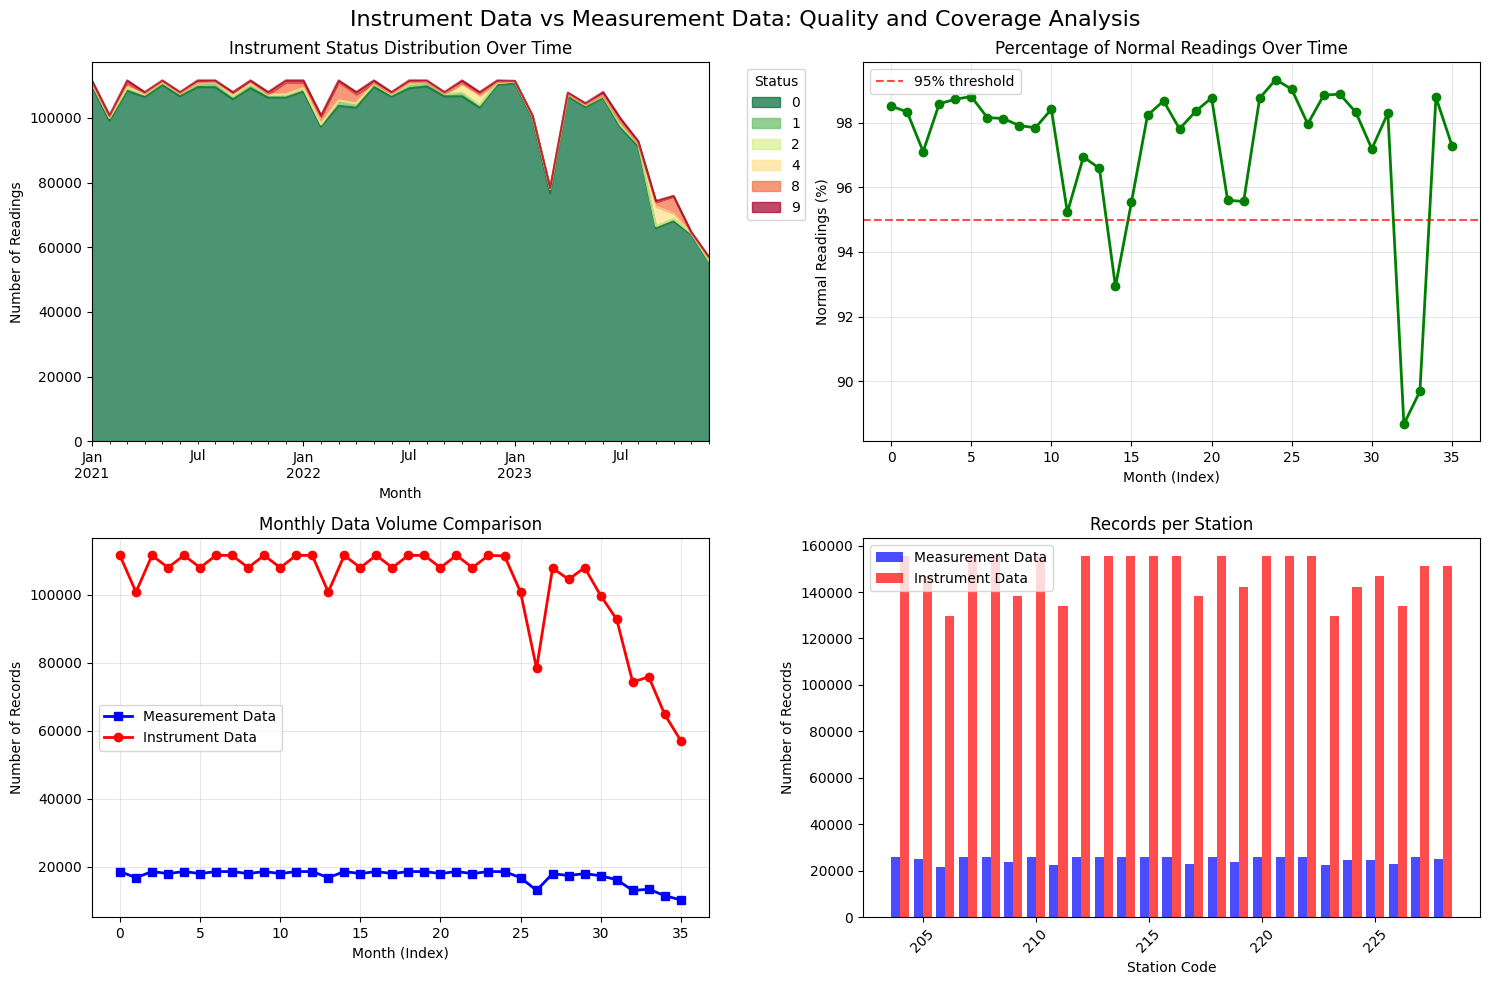

In [30]:
# 7. Visual Comparison: Data Quality Over Time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Instrument Data vs Measurement Data: Quality and Coverage Analysis', fontsize=16)

# Plot 1: Instrument status distribution over time
monthly_status = instrument_df.copy()
monthly_status['month'] = monthly_status['measurement_datetime'].dt.to_period('M')
status_by_month = monthly_status.groupby(['month', 'instrument_status']).size().unstack(fill_value=0)

status_by_month.plot(kind='area', stacked=True, ax=axes[0,0], 
                     colormap='RdYlGn_r', alpha=0.7)
axes[0,0].set_title('Instrument Status Distribution Over Time')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Number of Readings')
axes[0,0].legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Normal vs Abnormal readings percentage
normal_pct = (status_by_month[0] / status_by_month.sum(axis=1) * 100)
axes[0,1].plot(range(len(normal_pct)), normal_pct.values, 'g-', linewidth=2, marker='o')
axes[0,1].set_title('Percentage of Normal Readings Over Time')
axes[0,1].set_xlabel('Month (Index)')
axes[0,1].set_ylabel('Normal Readings (%)')
axes[0,1].grid(True, alpha=0.3)
axes[0,1].axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
axes[0,1].legend()

# Plot 3: Data volume comparison
meas_monthly = measurement_df.copy()
meas_monthly['month'] = meas_monthly['measurement_datetime'].dt.to_period('M')
meas_counts = meas_monthly.groupby('month').size()
instr_counts = monthly_status.groupby('month').size()

months_range = range(min(len(meas_counts), len(instr_counts)))
axes[1,0].plot(months_range, meas_counts.values[:len(months_range)], 'b-', 
               linewidth=2, marker='s', label='Measurement Data')
axes[1,0].plot(months_range, instr_counts.values[:len(months_range)], 'r-', 
               linewidth=2, marker='o', label='Instrument Data')
axes[1,0].set_title('Monthly Data Volume Comparison')
axes[1,0].set_xlabel('Month (Index)')
axes[1,0].set_ylabel('Number of Records')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Station coverage comparison
station_meas_counts = measurement_df.groupby('station_code').size().sort_index()
station_instr_counts = instrument_df.groupby('station_code').size().sort_index()

axes[1,1].bar(station_meas_counts.index - 0.2, station_meas_counts.values, 
              width=0.4, alpha=0.7, label='Measurement Data', color='blue')
axes[1,1].bar(station_instr_counts.index + 0.2, station_instr_counts.values, 
              width=0.4, alpha=0.7, label='Instrument Data', color='red')
axes[1,1].set_title('Records per Station')
axes[1,1].set_xlabel('Station Code')
axes[1,1].set_ylabel('Number of Records')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Key Insights: Instrument Data vs Measurement Data

Based on the comprehensive analysis above, here are the key findings about the relationship between these datasets:

### 🔍 **Primary Differences**

1. **Data Format**:
   - **Measurement Data**: Wide format (621K rows, pollutants as columns)
   - **Instrument Data**: Long format (3.7M rows, one row per pollutant reading)

2. **Unique Features**:
   - **Measurement Data**: Contains `latitude` and `longitude` for spatial analysis
   - **Instrument Data**: Contains `instrument_status` for data quality assessment

3. **Data Quality Information**:
   - **Measurement Data**: No quality indicators - appears to be "analysis-ready"
   - **Instrument Data**: Rich quality metadata with status codes (0-9)

### 📊 **Relationship Analysis**

- **Same Core Data**: Both datasets contain the same underlying pollution measurements
- **Different Perspectives**: 
  - Measurement data = "What pollution levels were measured?"
  - Instrument data = "How reliable were those measurements?"

### 🎯 **Use Case Recommendations**

| Task | Best Dataset | Reason |
|------|-------------|---------|
| **EDA Questions (Task 1)** | Measurement Data | Wide format easier for analysis, includes coordinates |
| **Forecasting (Task 2)** | Measurement Data | Clean format, ready for ML models |
| **Anomaly Detection (Task 3)** | Instrument Data | Contains status codes to identify instrument failures |
| **Data Quality Assessment** | Instrument Data | Has quality metadata and status information |
| **Spatial Analysis** | Measurement Data | Contains lat/lon coordinates |

### 💡 **Next Steps for Your Analysis**

1. **For EDA tasks**: Use `lnd_measurements` (measurement data)
2. **For anomaly detection**: Use `lnd_instrument_data` filtered by `instrument_status != 0`
3. **For highest quality forecasting**: Consider filtering instrument data to `instrument_status = 0` only

The datasets are complementary - measurement data gives you the "what", while instrument data gives you the "how reliable" context!